<a href="https://colab.research.google.com/github/blackdragonae/h0wsh2021/blob/main/HubbleConstant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://)
**La constantante de Hubble con Galaxias HII**
---



Sincronizando el Drive de google

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Instalando la librerias de python para hacer los calculos:

In [2]:
!pip install zeus-mcmc
!pip install getdist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importando las librerias necesarias para los calculos

In [14]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import os
from astropy.table import Table
from astropy.cosmology import FlatwCDM
from getdist import plots, MCSamples
import zeus
from zeus import ChainManager
import numpy as np
import scipy.optimize as op
from multiprocessing import Pool

Función Log Likelihood

In [4]:
def lnlike(theta, x, y, z, xerr, yerr, zerr):
    alpha, beta, h0 = theta

    Or = 4.153e-5 * h0**(-2)
    Om = 0.3
    w0 = -1.0

    cosmo = FlatwCDM(H0=h0*100, Om0=Om, w0=w0)
    #---------------------------------------------------------------------------
    ixG = np.where(z>10)
    ixH = np.where(z<10)

    Mum = z*0.0
    MumErr = z*0.0

    Mum[ixG] = z[ixG]
    MumErr[ixG] = zerr[ixG]

    Mum[ixH] = 5.0*np.log10(cosmo.luminosity_distance(z[ixH]).value) + 25.0
    MumErr[ixH] = (5.0/np.log(10.0))*(zerr[ixH]/z[ixH])

    Mu = 2.5*(beta*x + alpha) - 2.5*y - 100.195
    MuErr = 2.5*np.sqrt((yerr)**2 + beta**2*(xerr)**2)

    R = (Mu - Mum)
    W = 1.0/(MuErr**2 + MumErr**2)

    xsq = np.sum(R**2*W)
    llq = -0.5*xsq
    return (llq, xsq, R, Mum)

Definición de los priors

In [5]:
def lnprior(theta):
    alpha, beta, h0 = theta
    if (0.0 <= beta <= 10.0 and 20.0 <= alpha <= 40.0 and 0.5 <= h0 <= 1.0):
        return 0.0
    return -np.inf

Función de Log Posterior

In [6]:
def lnpost(theta, x, y, z, xerr, yerr, zerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, z, xerr, yerr, zerr)[0]

Función de lectura de datos

In [18]:
def h2gdat(dpath):
    LSL = 1.83
    Tpath = dpath+'indat/Union2020v16.dat'
    data = Table.read(Tpath, format='ascii', comment='#')

    vix = data['col1']

    vx = data['col2']
    vy = data['col3']
    vz = data['col4']

    vxErr = data['col5']
    vyErr = data['col6']
    vzErr = data['col7']

    vsp = data['col8']

    rXY = np.corrcoef(vx, vy)
    vRxy = vx*0.0 + rXY[0,1]

    ix = np.where((vx - vxErr) <= LSL)

    return (vix[ix], vx[ix], vy[ix], vz[ix], vxErr[ix], vyErr[ix], vzErr[ix],
            vRxy[ix], vsp[ix])

Inicio del codigo principal, definición del directorio de datos

In [19]:
# Main Code
dpath = '/content/drive/MyDrive/h0wsh2023/dat/'
print('Data path:', dpath)

Data path: /content/drive/MyDrive/h0wsh2023/dat/


Leyendo los datos

In [20]:
# Reading Data
vTg, vx, vy, vz, vxErr, vyErr, vzErr, vRxy, vsp = h2gdat(dpath)

Aproximación inicial para el resultado

In [21]:
# First guess
parameters = [r"\alpha", r"\beta", r"h"]
ialpha = 32.0
ibeta = 5.0
ih0 = 0.75

Cálculo de maximización de probablilidad

In [22]:
# Maximum Likelihood
nll = lambda *args: -lnlike(*args)[0]
result = op.minimize(nll, [ialpha, ibeta, ih0],
                args=(vx, vy, vz, vxErr, vyErr, vzErr)
            )
alpha_ml, beta_ml, h0_ml = result["x"]

print('max llq results:')
print('alpha = ', alpha_ml)
print('beta = ', beta_ml)
print('h = ', h0_ml)

max llq results:
alpha =  33.22505611458108
beta =  5.039317130800782
h =  0.7169651386623083


Cálculo de MCMC

In [23]:
# MCMC
nsteps = 1000
ndim, nwalkers = 3, 10
start = [[alpha_ml, beta_ml, h0_ml] + 1e-5*np.random.randn(ndim)
       for i in range(nwalkers)]

#with Pool() as pool:
sampler = zeus.EnsembleSampler(nwalkers, ndim, lnpost,
                                 args=(vx, vy, vz, vxErr, vyErr, vzErr)) #, pool=pool)
sampler.run_mcmc(start, nsteps)

sampler.summary

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 3
Number of Walkers: 10
Number of Tuning Generations: 42
Scale Factor: 0.968733
Mean Integrated Autocorrelation Time: 4.61
Effective Sample Size: 2167.17
Number of Log Probability Evaluations: 52052
Effective Samples per Log Probability Evaluation: 0.041635


Visulización de la cadena calculada

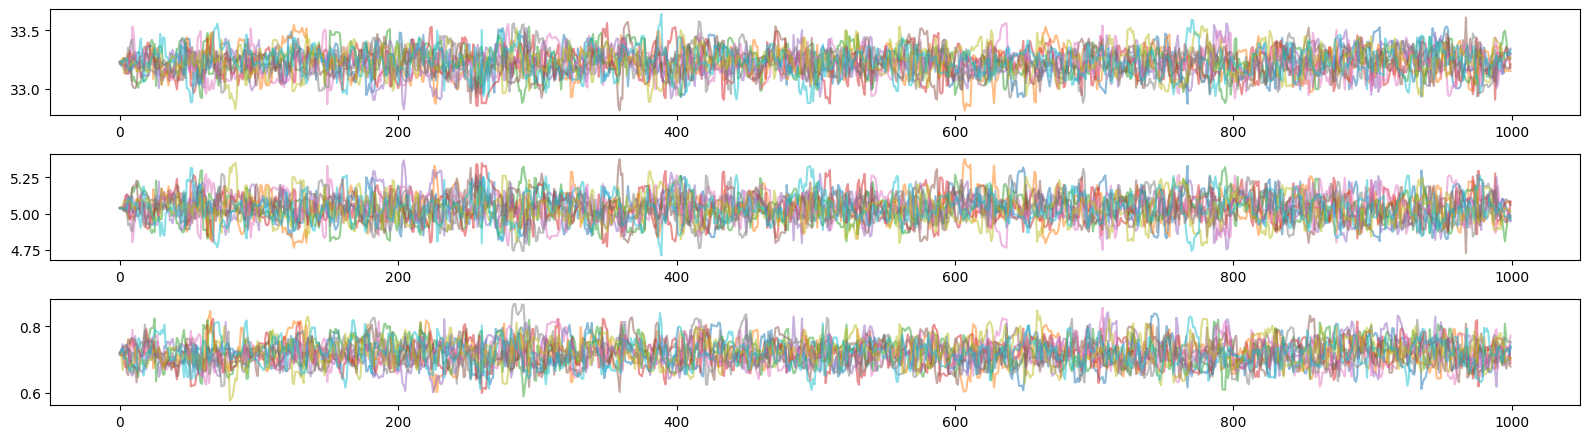

In [24]:
path = dpath+'results/chain_test.pdf'
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,n], alpha=0.5)
plt.tight_layout()
plt.savefig(path)
plt.show()

Eliminando burn-in y aplanando las cadenas

In [25]:
# flatten the chains, thin them by a factor of 1, and remove the burn-in (first 25% of the chain)
chain = sampler.get_chain(flat=True, discard=nsteps//4, thin=1)

Graficando resultados

Removed no burn in


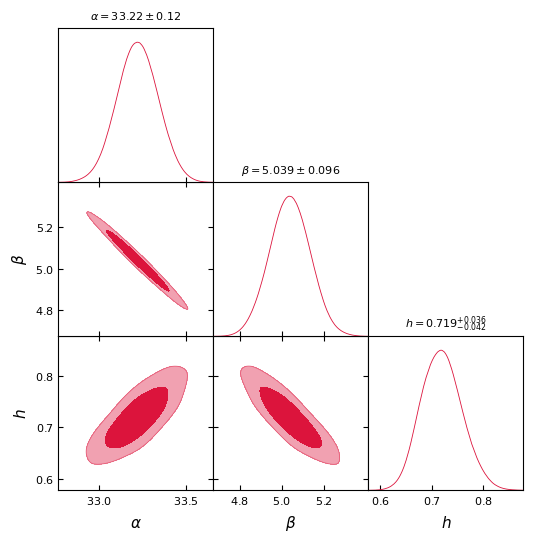

In [26]:
tag = 'GDplot'
path = dpath+'results/GDplot.pdf'
GDsamples = MCSamples(samples=chain, names=parameters,
                          labels=parameters, name_tag=tag #,
                          # ranges={r"\Omega_m":[0.0, None]}
                          )

g = plots.getSubplotPlotter() #width_inch=4
g.settings.num_plot_contours = 2
g.triangle_plot(GDsamples, filled=True, title_limit=1,
            contour_colors=['crimson']
            # , param_limits={r"\alpha":[32.8, 33.7]
                        # , r"\beta":[4.7, 5.35]
                        # , r"h":[0.6, 0.85]
                        # , r"\Omega_m":[0.0, 0.52]
                        # , r"w_0":[-2.1, -0.2]
                        # }
            )
g.export(path)

Imprimiendo los resultados

In [ ]:
t = GDsamples.getTable(limit=1).tableTex()
theta = GDsamples.getMeans()

# Print parameter values
print('parameter values:')
for name, col in zip(parameters, chain.transpose()):
  print('%15s : %.3f +- %.3f' % (name, col.mean(), col.std()))

print(t)

**Ejercicio 1:** Con el mismo procedimiento calcualar el conjunto de parametros ${\alpha, \beta, h, \Omega_m}$ utilizando un prior de $0.0 < \Omega_m < 1.0$


In [ ]:
def lnlike(theta, x, y, z, xerr, yerr, zerr):
    alpha, beta, h0, Om = theta

    Or = 4.153e-5 * h0**(-2)
    w0 = -1.0

    cosmo = FlatwCDM(H0=h0*100, Om0=Om, w0=w0)
    #---------------------------------------------------------------------------
    ixG = np.where(z>10)
    ixH = np.where(z<10)

    Mum = z*0.0
    MumErr = z*0.0

    Mum[ixG] = z[ixG]
    MumErr[ixG] = zerr[ixG]

    Mum[ixH] = 5.0*np.log10(cosmo.luminosity_distance(z[ixH]).value) + 25.0
    MumErr[ixH] = (5.0/np.log(10.0))*(zerr[ixH]/z[ixH])

    Mu = 2.5*(beta*x + alpha) - 2.5*y - 100.195
    MuErr = 2.5*np.sqrt((yerr)**2 + beta**2*(xerr)**2)

    R = (Mu - Mum)
    W = 1.0/(MuErr**2 + MumErr**2)

    xsq = np.sum(R**2*W)
    llq = -0.5*xsq
    return (llq, xsq, R, Mum)

In [ ]:
def lnprior(theta):
    alpha, beta, h0, Om = theta
    if (0.0 <= beta <= 10.0 and 20.0 <= alpha <= 40.0 and 0.5 <= h0 <= 1.0 and 0.0 <= Om <= 1.0):
        return 0.0
    return -np.inf

In [ ]:
def lnpost(theta, x, y, z, xerr, yerr, zerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, z, xerr, yerr, zerr)[0]

In [ ]:
# First guess
parameters = [r"\alpha", r"\beta", r"h", r"\Omega_m"]
ialpha = 32.0
ibeta = 5.0
ih0 = 0.75
iOm = 0.3

In [ ]:
# MCMC
nsteps = 1000
ndim, nwalkers = 4, 10
start = [[ialpha, ibeta, ih0, iOm] + 1e-5*np.random.randn(ndim)
       for i in range(nwalkers)]

with Pool() as pool:
  sampler = zeus.EnsembleSampler(nwalkers, ndim, lnpost, maxiter=20000,
                                 args=(vx, vy, vz, vxErr, vyErr, vzErr), pool=pool)
  sampler.run_mcmc(start, nsteps)

sampler.summary

In [ ]:
path = dpath+'results/chain_test_Om.pdf'
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,n], alpha=0.5)
plt.tight_layout()
plt.savefig(path)
plt.show()

In [ ]:
# flatten the chains, thin them by a factor of 1, and remove the burn-in (first 25% of the chain)
chain = sampler.get_chain(flat=True, discard=nsteps//4, thin=1)

In [ ]:
tag = 'GDplot'
path = dpath+'results/GDplotOm.pdf'
GDsamples = MCSamples(samples=chain, names=parameters,
                          labels=parameters, name_tag=tag
                        , ranges={r"\Omega_m":[0.0, None]}
                          )

g = plots.getSubplotPlotter() #width_inch=4
g.settings.num_plot_contours = 2
g.triangle_plot(GDsamples, filled=True, title_limit=1,
            contour_colors=['crimson']
            # , param_limits={r"\alpha":[32.8, 33.7]
                        # , r"\beta":[4.7, 5.35]
                        # , r"h":[0.6, 0.85]
                        # , r"\Omega_m":[0.0, 0.52]
                        # , r"w_0":[-2.1, -0.2]
                        # }
            )
g.export(path)

**Ejercicio 2:** Con el mismo procedimiento calcualar el conjunto de parametros ${\alpha, \beta, h, \Omega_m, w_0}$ utilizando un prior de $0.0 < \Omega_m < 1.0$ y $-2.0 < w_0 < 1.0$

**Ejercicio 3:** Con el mismo procedimiento calcualar $h, \Omega_m, w_0$ fijando los valores de $\alpha = 33.22\pm 0.12$ y $\beta = 5.044\pm 0.094$.

In [ ]:
def lnlike(theta, x, y, z, xerr, yerr, zerr):
    h0, Om, w0 = theta

    Or = 4.153e-5 * h0**(-2)

    alpha = 33.22
    alphaErr = 0.12
    beta = 5.044
    betaErr = 0.094

    cosmo = FlatwCDM(H0=h0*100, Om0=Om, w0=w0)
    #---------------------------------------------------------------------------
    ixG = np.where(z>10)
    ixH = np.where(z<10)

    Mum = z*0.0
    MumErr = z*0.0

    Mum[ixG] = z[ixG]
    MumErr[ixG] = zerr[ixG]

    Mum[ixH] = 5.0*np.log10(cosmo.luminosity_distance(z[ixH]).value) + 25.0
    MumErr[ixH] = (5.0/np.log(10.0))*(zerr[ixH]/z[ixH])

    Mu = 2.5*(beta*x + alpha) - 2.5*y - 100.195
    MuErr = 2.5*np.sqrt((yerr)**2 + beta**2*(xerr)**2 + x**2*(betaErr)**2 + alphaErr**2)

    R = (Mu - Mum)
    W = 1.0/(MuErr**2 + MumErr**2)

    xsq = np.sum(R**2*W)
    llq = -0.5*xsq
    return (llq, xsq, R, Mum)

In [ ]:
def lnprior(theta):
    h0, Om, w0 = theta
    if (0.5 <= h0 <= 1.0 and 0.0 <= Om <= 1.0 and -2.0 <= w0 <= 1.0):
        return 0.0
    return -np.inf

In [ ]:
def lnpost(theta, x, y, z, xerr, yerr, zerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, z, xerr, yerr, zerr)[0]

In [ ]:
# First guess
parameters = [r"h_0", r"\Omega_m", r"w_0"]
ih0 = 0.75
iOm = 0.3
iw0 = -1.0


In [ ]:
# MCMC
nsteps = 1000
ndim, nwalkers = 3, 10
start = [[ih0, iOm, iw0] + 1e-5*np.random.randn(ndim)
       for i in range(nwalkers)]

with Pool() as pool:
  sampler = zeus.EnsembleSampler(nwalkers, ndim, lnpost,
                                 args=(vx, vy, vz, vxErr, vyErr, vzErr), pool=pool)
  sampler.run_mcmc(start, nsteps)

sampler.summary

In [ ]:
path = dpath+'results/chain_test_w0.pdf'
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,n], alpha=0.5)
plt.tight_layout()
plt.savefig(path)
plt.show()

In [ ]:
# flatten the chains, thin them by a factor of 1, and remove the burn-in (first 25% of the chain)
chain = sampler.get_chain(flat=True, discard=nsteps//4, thin=1)

In [ ]:
tag = 'GDplot'
path = dpath+'results/GDplotw0.pdf'
GDsamples = MCSamples(samples=chain, names=parameters,
                          labels=parameters, name_tag=tag #,
                          # ranges={r"\Omega_m":[0.0, None]}
                          )

g = plots.getSubplotPlotter() #width_inch=4
g.settings.num_plot_contours = 2
g.triangle_plot(GDsamples, filled=True, title_limit=1,
            contour_colors=['crimson']
            # , param_limits={r"\alpha":[32.8, 33.7]
                        # , r"\beta":[4.7, 5.35]
                        # , r"h":[0.6, 0.85]
                        # , r"\Omega_m":[0.0, 0.52]
                        # , r"w_0":[-2.1, -0.2]
                        # }
            )
g.export(path)